(20, 20)


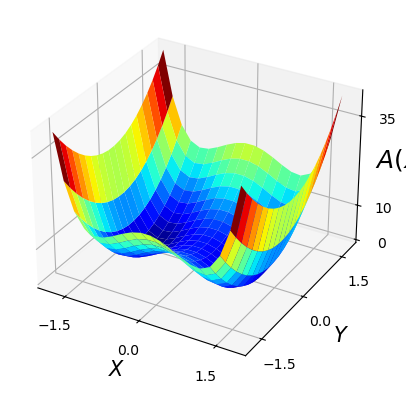

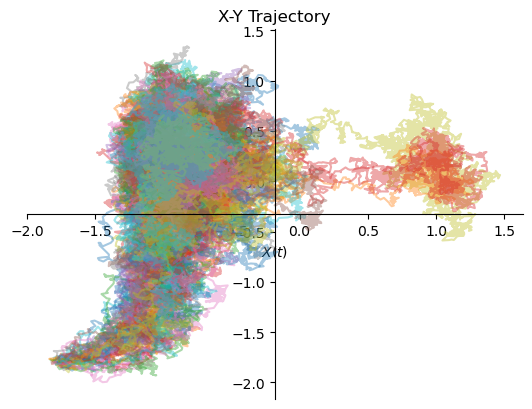

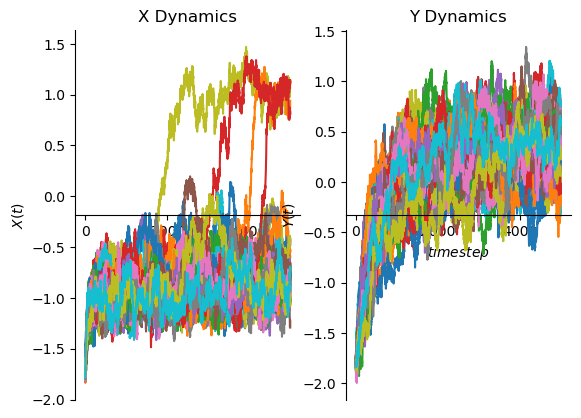

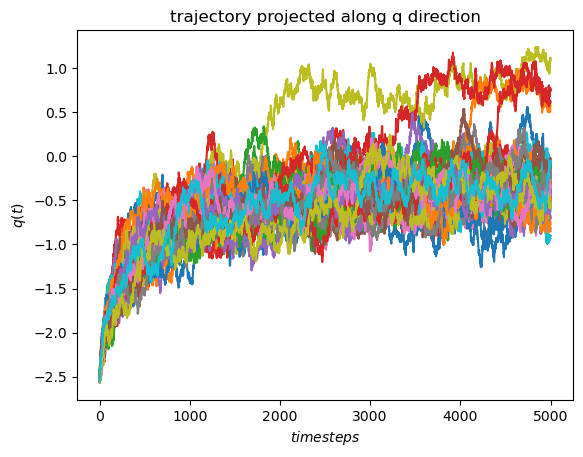

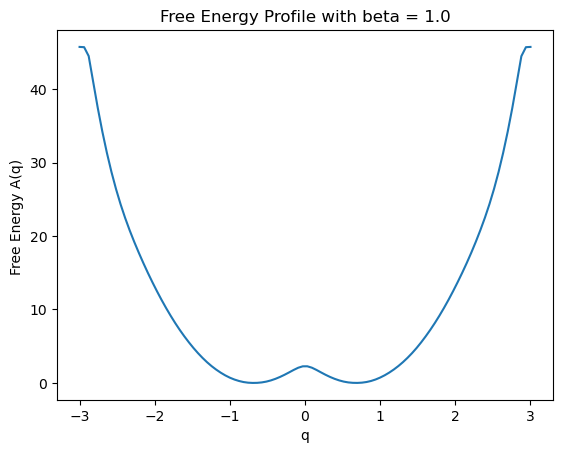

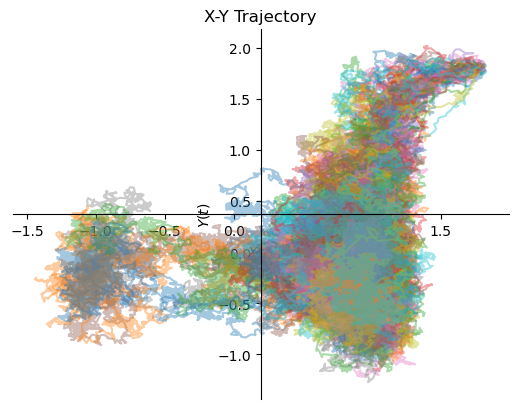

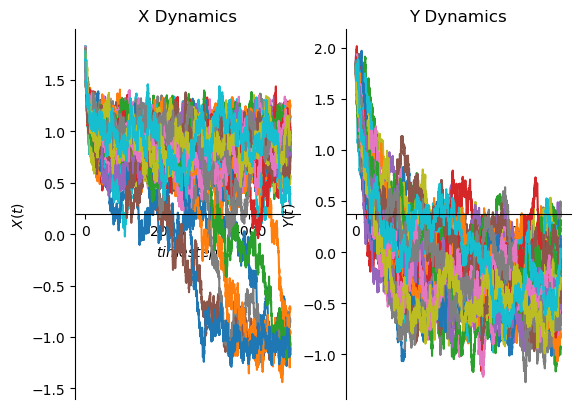

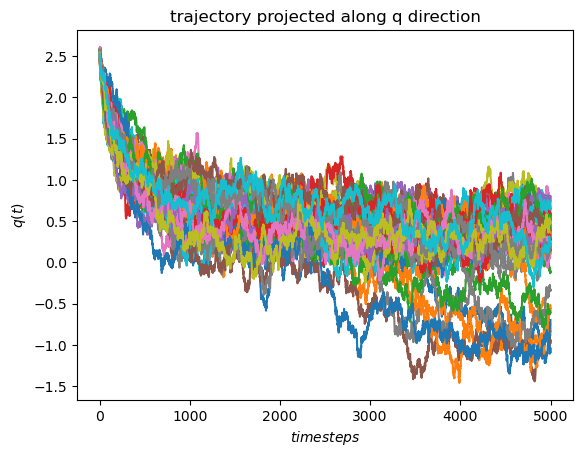

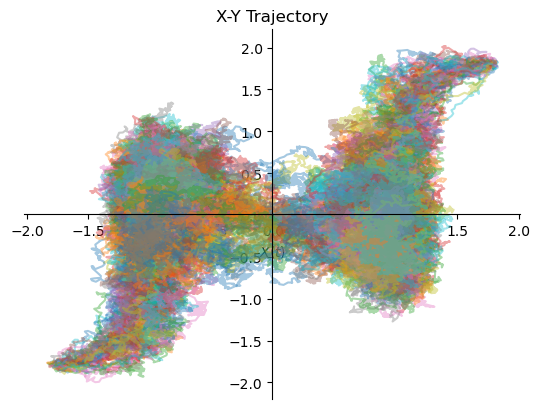

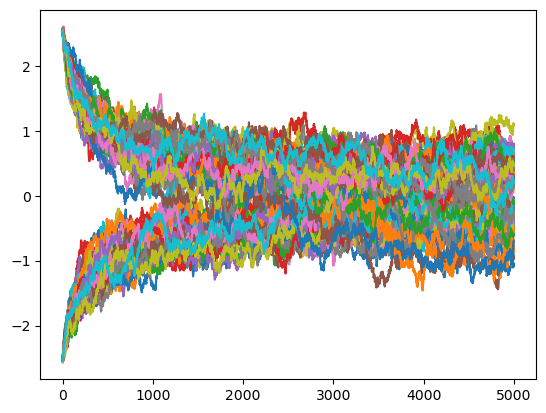

In [1]:
"""
================================
2D Double Well BIASED
================================

Estimation of an overdamped Langevin.
"""

import numpy as np
import matplotlib.pyplot as plt
import folie as fl
from mpl_toolkits.mplot3d import Axes3D
from copy import deepcopy
import scipy as sc
from MC_FES import MCFreeEnergy

x = np.linspace(-1.8, 1.8, 20)
y = np.linspace(-1.8, 1.8, 20)
input = np.transpose(np.array([x, y]))

D=0.5
diff_function= fl.functions.Polynomial(deg=0,coefficients=D * np.eye(2,2))
a,b = 5, 10
drift_quartic2d= fl.functions.Quartic2D(a=D*a,b=D*b)  # simple way to multiply D*Potential here force is the SDE force (meandispl)  ## use this when you need the drift ###
quartic2d= fl.functions.Quartic2D(a=a,b=b)            # Real potential , here force is just -grad pot ## use this when you need the potential energy ###

X, Y = np.meshgrid(x, y)

# Plot potential surface
pot = quartic2d.potential_plot(X, Y)
print(pot.shape)
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.plot_surface(X, Y, pot, rstride=1, cstride=1, cmap="jet", edgecolor="none")
ax.set_xlabel('$X$', fontsize=15)
ax.set_ylabel('$Y$',fontsize=15)
ax.zaxis.set_rotate_label(False) 
ax.set_yticks([-1.5,0, 1.5])
ax.set_xticks([-1.5,0, 1.5])
ax.set_zticks([0,10, 35])
ax.set_zlabel('$A(x,y)$', fontsize=18,rotation = 0)

def q(theta, x, y):                                                                 # here to change angle of projection
    return np.cos(theta) * x + np.sin(theta) * y
                                                            
theta=np.pi/4
def colvar(x, y):
    theta = np.pi/4
    return np.cos(theta) * x + np.sin(theta) * y, np.array([np.cos(theta),np.sin(theta)])  # need to return both colvar function q=q(x,y) and gradient (dq/dx,dq/dy)


####################################################################################################################################################################################

#                                                                 GENERATE FORWARD TRAJECTORY                                                                                      #

####################################################################################################################################################################################
dt=5e-4
model_simu = fl.models.overdamped.Overdamped(force=drift_quartic2d, diffusion=diff_function)
simulator = fl.simulations.ABMD_2D_to_1DColvar_Simulator(fl.simulations.EulerStepper(model_simu), dt, colvar=colvar, k=10.0, qstop=2.2)

# initialize positions
ntraj = 50
q0 = np.empty(shape=[ntraj, 2])
for i in range(ntraj):
    for j in range(2):
        q0[i][j] = -1.8

# Calculate Trajectory
time_steps = 5000
save_every = 1

forw_data = simulator.run(time_steps, q0, save_every=save_every)

# Plot the resulting trajectories in XY plane and in different subplots for X and Y separetly
fig, axs = plt.subplots()
fig, bb = plt.subplots(1, 2)
for n, trj in enumerate(forw_data): # une seule boucle qui fait le plot sur X,Y, et 2D avec le config du plot même, ainsi tu peut tout folder
    axs.plot(trj["x"][:, 0], trj["x"][:, 1],alpha=0.4)
    axs.spines["left"].set_position("center")
    axs.spines["right"].set_color("none")
    axs.spines["bottom"].set_position("center")
    axs.spines["top"].set_color("none")
    axs.xaxis.set_ticks_position("bottom")
    axs.yaxis.set_ticks_position("left")
    axs.set_xlabel("$X(t)$")
    axs.set_ylabel("$Y(t)$")
    axs.set_title("X-Y Trajectory")
    axs.grid()

    bb[0].plot(trj["x"][:, 0])
    bb[1].plot(trj["x"][:, 1])
    # Set visible  axis
    bb[0].spines["right"].set_color("none")
    bb[0].spines["bottom"].set_position("center")
    bb[0].spines["top"].set_color("none")
    bb[0].xaxis.set_ticks_position("bottom")
    bb[0].yaxis.set_ticks_position("left")
    bb[0].set_xlabel("$timestep$")
    bb[0].set_ylabel("$X(t)$")
    # Set visible axis
    bb[1].spines["right"].set_color("none")
    bb[1].spines["bottom"].set_position("center")
    bb[1].spines["top"].set_color("none")
    bb[1].xaxis.set_ticks_position("bottom")
    bb[1].yaxis.set_ticks_position("left")
    bb[1].set_xlabel("$timestep$")
    bb[1].set_ylabel("$Y(t)$")
    bb[0].set_title("X Dynamics")
    bb[1].set_title("Y Dynamics")


#########################################
#  Projection along chosen coordinate   #
#########################################

# u_norm = np.array([np.cos(theta), np.sin(theta)])
w = np.empty_like(trj["x"][:, 0])
s = np.empty_like(trj["x"][:, 0])
proj_forw_data = fl.Trajectories(dt=forw_data[0]['dt'])
fig, axs = plt.subplots()
for n, trj in enumerate(forw_data):
    for i in range(len(trj["x"])):
        w[i]= q(theta,trj["x"][i][0],trj["x"][i][1])
        s[i]= q(theta,trj["bias"][i][0],trj["bias"][i][1])
    proj_forw_data.append(fl.Trajectory(trj['dt'], deepcopy(w.reshape(len(trj["x"][:, 0]), 1)),bias = deepcopy(s.reshape(len(trj["x"][:, 0]), 1))))
    axs.plot(proj_forw_data[n]["x"])
    axs.set_xlabel("$timesteps$")
    axs.set_ylabel("$q(t)$")
    axs.set_title("trajectory projected along q direction")
    axs.grid()

#############################################################
# CREATE REFERENCE FOR FREE ENERGY USING IMPORTANCE SAMPLING #
# #############################################################
def Pot(x, y):
    a = 5
    b = 10
    return a * (x**2 - 1)**2 + 0.5*b * y**2
beta = 1.0
q_bins, A_q =MCFreeEnergy(q=q,V=Pot,theta=theta,beta =beta)
# Plot the free energy profile
fig, ip = plt.subplots()
ip.plot(q_bins, A_q - np.min(A_q))  # Shift so that the minimum A(q) is zero
ip.set_xlabel('q')
ip.set_ylabel('Free Energy A(q) ')
ip.set_title('Free Energy Profile with beta = '+str(beta))

####################################################################################################################################################################################

#                                                           GENERATE BACKWARD TRAJECTORY                                                                                           #

####################################################################################################################################################################################

model_simu = fl.models.overdamped.Overdamped(force=drift_quartic2d, diffusion=diff_function)
simulator = fl.simulations.ABMD_2D_to_1D_Back_Colvar_Simulator(fl.simulations.EulerStepper(model_simu), dt, colvar=colvar, k=10.0, qstop=-2.2)

# initialize positions
ntraj = 50
q0 = np.empty(shape=[ntraj, 2])
for i in range(ntraj):
    for j in range(2):
        q0[i][j] = 1.8

# Calculate Trajectory
time_steps = 5000
save_every = 1

back_data = simulator.run(time_steps, q0, save_every=save_every)

# Plot the resulting trajectories in XY plane and in different subplots for X and Y separetly
fig, axs = plt.subplots()
fig, bb = plt.subplots(1, 2)
for n, trj in enumerate(back_data):
    axs.plot(trj["x"][:, 0], trj["x"][:, 1],alpha=0.4)
    axs.spines["left"].set_position("center")
    axs.spines["right"].set_color("none")
    axs.spines["bottom"].set_position("center")
    axs.spines["top"].set_color("none")
    axs.xaxis.set_ticks_position("bottom")
    axs.yaxis.set_ticks_position("left")
    axs.set_xlabel("$X(t)$")
    axs.set_ylabel("$Y(t)$")
    axs.set_title("X-Y Trajectory")
    axs.grid()

    bb[0].plot(trj["x"][:, 0])
    bb[1].plot(trj["x"][:, 1])
    # Set visible  axis
    bb[0].spines["right"].set_color("none")
    bb[0].spines["bottom"].set_position("center")
    bb[0].spines["top"].set_color("none")
    bb[0].xaxis.set_ticks_position("bottom")
    bb[0].yaxis.set_ticks_position("left")
    bb[0].set_xlabel("$timestep$")
    bb[0].set_ylabel("$X(t)$")
    # Set visible axis
    bb[1].spines["right"].set_color("none")
    bb[1].spines["bottom"].set_position("center")
    bb[1].spines["top"].set_color("none")
    bb[1].xaxis.set_ticks_position("bottom")
    bb[1].yaxis.set_ticks_position("left")
    bb[1].set_xlabel("$timestep$")
    bb[1].set_ylabel("$Y(t)$")
    bb[0].set_title("X Dynamics")
    bb[1].set_title("Y Dynamics")

#########################################
#  Projection along chosen coordinate   #
#########################################

# u_norm = np.array([np.cos(theta), np.sin(theta)])
w = np.empty_like(trj["x"][:, 0])
s = np.empty_like(trj["x"][:, 0])
proj_back_data = fl.Trajectories(dt=back_data[0]['dt'])
fig, axs = plt.subplots()
for n, trj in enumerate(back_data):
    for i in range(len(trj["x"])):
        w[i]= q(theta,trj["x"][i][0],trj["x"][i][1])
        s[i]= q(theta,trj["bias"][i][0],trj["bias"][i][1])
    proj_back_data.append(fl.Trajectory(trj['dt'], deepcopy(w.reshape(len(trj["x"][:, 0]), 1)),bias = deepcopy(s.reshape(len(trj["x"][:, 0]), 1))))
    axs.plot(proj_back_data[n]["x"])
    axs.set_xlabel("$timesteps$")
    axs.set_ylabel("$q(t)$")
    axs.set_title("trajectory projected along q direction")
    axs.grid()


#####################################################################
#  Put the two trjectories togheter to be used for the training 
#####################################################################
full_data= fl.Trajectories(dt=forw_data[0]["dt"])
proj_full_data = fl.Trajectories(dt=dt)

fig, ll = plt.subplots()
fig, dd = plt.subplots()

for n,trj in enumerate(forw_data):
    full_data.append(fl.Trajectory(trj['dt'], deepcopy(trj["x"]),bias = deepcopy(trj["bias"])))
    proj_full_data.append(fl.Trajectory(trj['dt'], deepcopy(proj_forw_data[n]["x"]), bias = deepcopy(proj_forw_data[n]["bias"])))
for n,trj in enumerate(back_data):
    full_data.append(fl.Trajectory(trj['dt'], deepcopy(trj["x"]),bias = deepcopy(trj["bias"])))
    proj_full_data.append(fl.Trajectory(trj['dt'], deepcopy(proj_back_data[n]["x"]), bias = deepcopy(proj_back_data[n]["bias"])))

for n,trj in enumerate(full_data):

    ll.plot(full_data[n]["x"][:, 0], full_data[n]["x"][:, 1],alpha=0.4)
    dd.plot(proj_full_data[n]["x"])

    ll.spines["left"].set_position("center")
    ll.spines["right"].set_color("none")
    ll.spines["bottom"].set_position("center")
    ll.spines["top"].set_color("none")
    ll.xaxis.set_ticks_position("bottom")
    ll.yaxis.set_ticks_position("left")
    ll.set_xlabel("$X(t)$")
    ll.set_ylabel("$Y(t)$")
    ll.set_title("X-Y Trajectory")
    ll.grid()



In [3]:
       ########        ########        ########        ########        ########        ########        ########        ########        ########        ########        ########        ########        
########        ########        ########        ########        ########        ########        ########        ########        ########        ########        ########        ########        ########

#                                                                                 T R A I N I N G 

        ########        ########        ########        ########        ########        ########        ########        ########        ########        ########        ########        ########        
########        ########        ########        ########        ########        ########        ########        ########        ########        ########        ########        ########        ########

domain = fl.MeshedDomain.create_from_range(np.linspace(proj_full_data.stats.min, proj_full_data.stats.max, 4).ravel())
trainmodel = fl.models.Overdamped(force = fl.functions.BSplinesFunction(domain),has_bias=True)

xfa = np.linspace(proj_full_data.stats.min, proj_full_data.stats.max, 75)
xfa =np.linspace(-1.6,1.6,75)


fig, axs = plt.subplots(1, 2)
axs[0].set_title("Force")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x)$")
axs[0].grid()
axs[1].set_title("Diffusion")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$D(x)$")
axs[1].grid()

fig,axb = plt.subplots()
axb.set_title("Free Energy (MLE) along frame rotated by $ϑ = \pi/4$")
axb.set_xlabel("$q$")
axb.set_ylabel("$A_{MLE}(q)$")
axb.grid()

KM_Estimator = fl.KramersMoyalEstimator(deepcopy(trainmodel))
res_KM = KM_Estimator.fit_fetch(proj_full_data)

axs[0].plot(xfa, res_KM.force(xfa.reshape(-1, 1)), color='grey', marker="x",label="KramersMoyal")
axs[1].plot(xfa, res_KM.diffusion(xfa.reshape(-1, 1)), color='grey',marker="x",label="KramersMoyal")
print("KramersMoyal ", res_KM.coefficients)
for name,marker,color, transitioncls in zip(
["Euler", "Elerian", "Kessler", "Drozdov"],
    ["|","1","2","3"],
    ["#1f77b4ff","#9e4de6ff","#2ca02cff","#ff7f0eff"],
[
    fl.EulerDensity,
    fl.ElerianDensity,
    fl.KesslerDensity,
    fl.DrozdovDensity,
],
):
    estimator = fl.LikelihoodEstimator(transitioncls(deepcopy(trainmodel)),n_jobs=4)
    res = estimator.fit_fetch(deepcopy(proj_full_data))
    res.remove_bias()
    print(name, res.coefficients)
    axs[0].plot(xfa, res.force(xfa.reshape(-1, 1)),marker=marker,color=color, label=name)
    axs[1].plot(xfa, res.diffusion(xfa.reshape(-1, 1)),marker=marker,color=color, label=name)
    fes = fl.analysis.free_energy_profile_1d(res,xfa)
    axb.plot(xfa, fes,marker,color=color, label=name)
    axb.set_ylim(-0.5,7)
axb.plot(q_bins, A_q - np.min(A_q),color ="#bd041cff",label ="MC sampling")  # Shift so that the minimum A(q) is zero

# axb.plot(q,A-A[37],color="#bd041cff",label='Numerically integrated')

axs[0].legend()
axs[1].legend()
axb.legend()

<>:27: SyntaxWarning: invalid escape sequence '\p'
<>:27: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_71980/2901390475.py:27: SyntaxWarning: invalid escape sequence '\p'
  axb.set_title("Free Energy (MLE) along frame rotated by $ϑ = \pi/4$")


KramersMoyal  [ 36.19849046 -51.96710407  52.24634071 -36.6568761    0.4881805
   0.51341001   0.49876827   0.50584108]
Euler [ 39.27205209 -49.17051283  49.17073951 -39.80560648   0.49294637
   0.51143105   0.49279036   0.51299194]
Elerian [ 39.40680469 -49.16164802  49.3809124  -39.81547199   0.49725769
   0.50740911   0.49353682   0.51450056]
